# Solar System

#### Mark Croom, Hannah Gallamore, Dylan Gatlin, Cristo Sanchez

Based on the tests in python_tests.ipynb, the Fortran adaptive timestep model
 is ready for
 use, but in order to interact with the data, we will need to run it through
 Python using f2py. This will enable us to plot our outputs easily.
 
 
### A Word of Caution
This model doesn't throw out points mid-execution. An 64 bit integer (8 Bytes),
 stored in two 3x10x~ 2 Million sized arrays, as well as a time array, means 
 that
 this model will crash with less than 10 GB of free memory. It will also need
 some overhead for plotting. It will also take 75s per 100 years. Only run it
 when absolutely necessary, with only things that are absolutely necessary
 open.

In [1]:
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astroquery.jplhorizons import Horizons
from matplotlib.animation import FuncAnimation
from astropy.time import Time
import fortpy as fp
sns.set(style='darkgrid')

## Fetching a Dataset
Most of what we need can be found via Horizons' Python interface. However, mass
 is not accessible there (although it's in the actual database), so it was 
 copied manually.

In [11]:
bodies = ["Sun", "Mercury Barycenter", "Venus Barycenter",
          "Earth-Moon Barycenter", "Mars Barycenter", "Jupiter Barycenter",
          "Saturn Barycenter", "Uranus Barycenter", "Neptune Barycenter",
          "Pluto Barycenter"]
masses = np.array([1.989e33, 0.3302e27, 4.8685e27, 5.9736e27, 0.64185e27, 
                   1898.6e27, 568.46e27, 86.832e27, 102.43e27, 0.01303e27])
ss_masses = masses / masses[0]
ss_i_poses = []
ss_i_vels = []
today = Time.now()
for body in bodies:
    qry = Horizons(id=body, epochs={'start':today.iso[:10],
                                    'stop': (today + 1).iso[:10],
                                 'step':'2d'}, id_type='majorbody')
    ss_i_poses.append([qry.vectors()[0]['x'], qry.vectors()[0]['y'],
                       qry.vectors()[0]['z']])
    ss_i_vels.append([qry.vectors()[0]['vx'], qry.vectors()[0]['vy'],
                      qry.vectors()[0]['vz']])
ss_i_poses = np.array(ss_i_poses).astype(order='F', dtype=float)
ss_i_vels = np.array(ss_i_vels).astype(order='F', dtype=float)

## Pure Fortran


In [3]:
dt_0 = 1e-3
ss_times = []
ss_poses = []
now = time.time()
years = 1000
ss_times, ss_poses, ss_vels, ss_status = fp.n_bodies.adaptive_n_body_model(
    "rkf45", 25000 * years, ss_masses, ss_i_poses, ss_i_vels, 365 * years,
    1e-10, dt_0, 4, 0.00029591220828559, 1)
new = time.time()
ss_filt = ss_times > 0
ss_filt[0] = True
lim = ss_filt.sum()
ss_times = ss_times[:lim:2]
ss_poses = ss_poses[:lim:2]
ss_vels = ss_vels[:lim:2]
print(f"Solar System Status: {ss_status.decode('utf-8')}")
print(f"Length: {ss_times.size}")
print(f"Time consumption: {new - now:.2f} s")

Solar System Status: SizeRisk, n_times too small for t_tot/dt=                                                                                                                                                                                                                       
Length: 10637549
Time consumption: 754.50 s


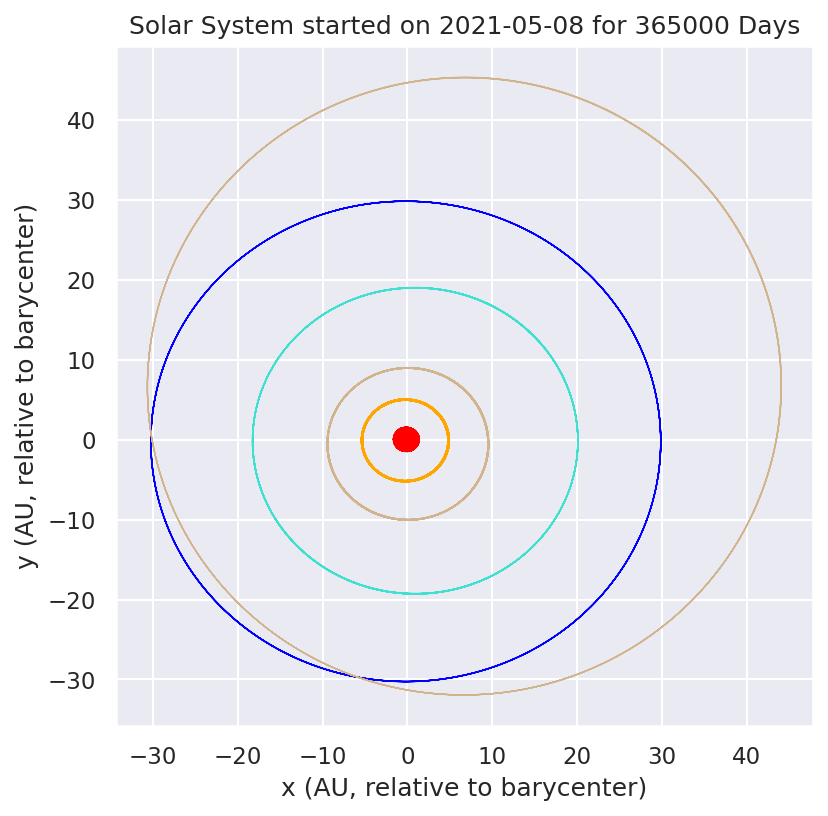

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150)
colors = ['orange', 'gray', 'yellow', 'green', 'red', 'orange', 'tan',
          'turquoise', 'blue', 'tan']
frame_skip = 10000
for i, body in enumerate(bodies):
    ax.plot(ss_poses[::frame_skip, i, 0],
            ss_poses[::frame_skip, i, 1],
            # s=(np.log(1 + ss_masses[i]) * 50 + 8),
            c=colors[i],
            # edgecolor='k',
            linewidth=0.6)
ax.set_xlabel("x (AU, relative to barycenter)")
ax.set_ylabel("y (AU, relative to barycenter)")
ax.set_title(f"Solar System started on {today.isot[:10]} for {ss_times[-1]:.0f} Days")
fig.savefig("spatial_plog.png")

In [5]:
indexes = [0]
dt_lim = 25.
for i, t in enumerate(ss_times):
    if t - ss_times[indexes[-1]] > dt_lim:
        indexes.append(i)

100%|██████████| 1459/1459 [09:51<00:00,  2.43it/s]

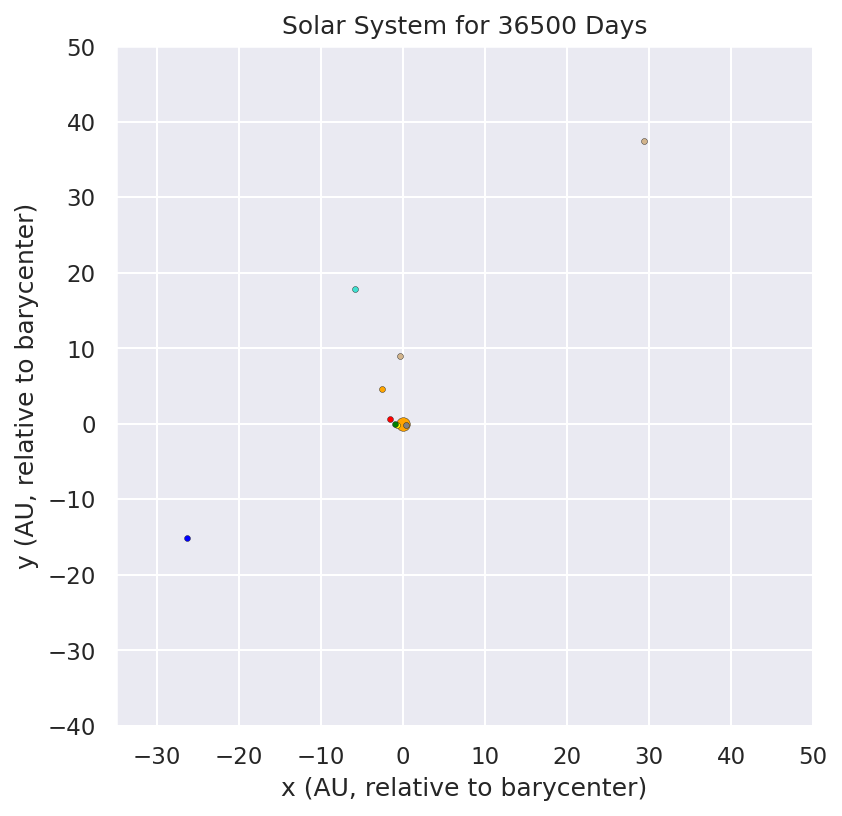

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150)
colors = ['orange', 'gray', 'yellow', 'green', 'red', 'orange', 'tan',
          'turquoise', 'blue', 'tan']
pbar = tqdm.tqdm(total=len(indexes)//10)
t = int(ss_times[-1] * 0.1) + 1
def init():
    for i, body in enumerate(bodies):
        line = ax.scatter(ss_poses[0, i, 0],
                          ss_poses[0, i, 1],
                          s=(np.log(1 + ss_masses[i]) * 50 + 8), 
                          c=colors[i], edgecolor='k', linewidth=0.2)
    ax.set_xlabel("x (AU, relative to barycenter)")
    ax.set_ylabel("y (AU, relative to barycenter)")
    ax.set_title(f"Solar System for {t:.0f} Days")
    ax.set_xlim(-35, 50)
    ax.set_ylim(-40, 50)
    return line

def update(i):
    pbar.update(1)
    ax.cla()
    for j, body in enumerate(bodies):
        line = ax.scatter(ss_poses[indexes[i], j, 0],
                          ss_poses[indexes[i], j, 1],
                          s=(np.log(1 + ss_masses[j]) * 50 + 8), 
                          c=colors[j], edgecolor='k', linewidth=0.2)
    ax.set_xlabel("x (AU, relative to barycenter)")
    ax.set_ylabel("y (AU, relative to barycenter)")
    ax.set_title(f"Solar System for {t:.0f} Days")
    ax.set_xlim(-35, 50)
    ax.set_ylim(-40, 50)
ani = FuncAnimation(fig, update, frames=len(indexes)//10,
                    init_func=init)
ani.save("solar_system_animation.mp4", writer="ffmpeg", fps=24)


100%|██████████| 4/4 [00:00<00:00, 24.00it/s]


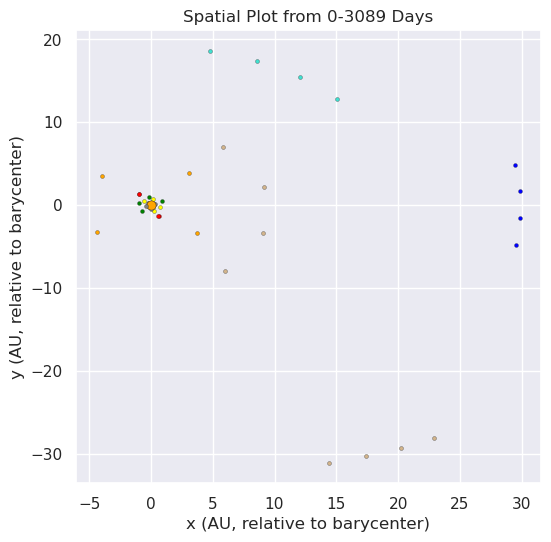

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
colors = ['orange', 'gray', 'yellow', 'green', 'red', 'orange', 'tan',
          'turquoise', 'blue', 'tan']
frame_skip = 30000
for j, t in tqdm.tqdm(list(enumerate(ss_times[:100000:frame_skip]))):
    for i, body in enumerate(bodies):
        ax.scatter(ss_poses[j * frame_skip, i, 0],
                   ss_poses[j * frame_skip, i, 1],
                   s=(np.log(1 + ss_masses[i]) * 50 + 8), c=colors[i],
                   edgecolor='k', linewidth=0.2)
ax.set_xlabel("x (AU, relative to barycenter)")
ax.set_ylabel("y (AU, relative to barycenter)")
ax.set_title(f"Spatial Plot from 0-{t:.0f} Days")
fig.savefig("spatial_plog.png")

## Python/Fortran Hybrid Model
In the early stages of this project, we weren't sure if the full-Fortran model
 would work, so we prepared a version with a Python wrapper around a Fortran
 integrator. Once we were sure the pure-Fortran method worked, we stopped 
 work here, so this may be out of date.

In [8]:
class Output(object):
    def __init__(self, masses=[], positions=[], velocities=[], times=[],
                 coms=[], avvs=[], energies=[], amomentums=[],
                 eccentricities=[], count=0, n_bodies=0):
        self.masses = masses
        self.positions = positions
        self.velocities = velocities
        self.times = times
        self.coms = coms
        self.avvs = avvs
        self.energies = energies
        self.amomentums = amomentums
        self.eccentricities = eccentricities
        self.count = count
        self.n_bodies = n_bodies
        self.model_out = [self.masses, self.positions, self.velocities,
                          self.times, self.coms, self.avvs, self.n_bodies]

    def calculate_auxilary_values(self, com=None, avv=None):
        """Computes the energy and angular momentum of a system of particles.
        The energy is computed as the kinetic energy of a particle minus the
        potential energy of every other particle relative to it. The angular
        momentum is the cross product of positions and velocities, relative to 
        the center of mass.
        """
        if com is None:
            com = self.coms
        if avv is None:
            avv = self.avvs
        nrg_rel = np.zeros(self.positions.shape[0])
        h_rel = np.zeros((self.positions.shape[0],) + (3,))

        for i in range(self.positions.shape[1]):
            # if masses[i] != 0:
            nrg_rel += 0.5 * np.linalg.norm(self.velocities[:, i, :]
                                            - avv, axis=1)**2
            for j in range(i+1, self.positions.shape[1]):
                # if masses[i] != 0:
                nrg_rel -= self.masses[i] / np.linalg.norm(
                    self.positions[:, i, :] - self.positions[:, j, :], axis=1
                    )
            h_rel += np.cross(self.positions[:, i, :] - com,
                              self.velocities[:, i, :] - avv)
        e_rel = np.sqrt(1 + 2 * nrg_rel * np.linalg.norm(h_rel, axis=1)
                        / np.sum(self.masses)**2)
        self.eccentricities = e_rel
        self.energies = nrg_rel
        self.amomentums = h_rel


def calc_com(masses, pos):
    """A simple function that compute the center of mass of a system
    """
    return (masses[:, None] * pos).sum(axis=0) / masses.sum()
    # return ((masses*pos.T).T).sum(axis = 0) / masses.sum()


def calc_avv(masses, vel):
    """A simple function that computes the average velocity of a system
    """
    return (masses[:, None] * vel).sum(axis=0) / masses.sum()
    # return ((masses*vel.T).T).sum(axis = 0) / masses.sum()


def adjust_timestep(dt, err, q, t_tot):
#     facmax = 6.
#     facmin = 0.33
    fac = 0.38**(1. / (1. + q))
    dt_new = dt * fac * err**(-1. / (1. + q))
#     if (dt_new > facmax * dt):
#         dt_new = facmax * dt
#     elif (dt_new < facmin * dt):
#         dt_new = facmin * dt
    if (dt_new / t_tot < 1e-12) or np.isnan(dt_new):
        dt_new = t_tot * 1e-12
    return dt_new


def adaptive_n_body(integrator, masses, i_positions, i_velocities,
                    t_tot, tolerance, dt_0=1e-2, q=2, g=1, update_com=True,
                    **kwargs):
    """
    An n-body time integrator, that simulates the positions and velocities of
    an ensemble of particles in a gravity field.
    Inputs:
    integrator: A function that computes new positions and velocities, which
     takes masses, positions, velocities, and a timestep as inputs, and returns
     a pair of positions and velocities, the first two are the lower-order
     positions and velocities, the second pair is the higher-order check of the
     positions and velocities
    masses: A 1-D array of particle masses
    i_positions: A 2-D array of shape particles*dimensions of particle initial
    positions
    i_velocities: A 2-D array of shape particles*dimensions of particle initial
    velocities
    t_tot: A float of the total time of integration
    dt: The timestep
    
    Note: The integration is done using jacobi coordinates (ie relative to a 
     center of mass reference frame. If your inputs are not given in a center
     of mass reference frame, your inputs may not look like the initial state of
     the outputs)

    Outputs:
    positions, velocities, times, center of masses, average velocities, all
     as arrays. Positions and velocities are 3-D arrays of shape
     times*particles*dimensions. Times is a 1-D array of shape times. Center
     of mass and average velocities are of shape times*dimensions and only
     represent the change of the center of mass and velocity in the previous
     time step

    """
    # All the information we need to compute the times is given at the start
    times = []
    positions = []
    velocities = []
    coms = []
    avvs = []
    errors = []
    # compute the center of mass and average velocities and update the inputs
    # before they are added to our data
    com = calc_com(masses, i_positions)
    avv = calc_avv(masses, i_velocities)
    if update_com:
        pos2 = i_positions - com
        vel2 = i_velocities - avv
    else:
        pos2 = i_positions
        vel2 = i_velocities
    t = 0.
    dt = dt_0
    err = 0.
    count = 0
    pbar = tqdm.tqdm(total=t_tot,bar_format='{desc}: {percentage:3.0f}'
    '% {n:.3f}/{total:.3f} [{elapsed}<{remaining}, {rate_fmt}{postfix}]')
    n_recalculates = 0
    while ((t < t_tot) and (count < 1000000)):
        pbar.update(dt)
        times.append(t)
        positions.append(pos2)
        velocities.append(vel2)
        coms.append(com)
        avvs.append(avv)
        errors.append(err)
#         second_count = 0
#         while second_count < 100:
        pos1, vel1, pos2, vel2 = integrator(masses, pos2, vel2, dt, g=g,
                                                **kwargs)
            # To handle most critical bugs in any integrator function, this will
            # raise an error if the outputs are nonsense
        if np.any(np.isnan(pos2)):
            raise ValueError('nan encountered')
        com = calc_com(masses, pos2)
        avv = calc_avv(masses, vel2)
        if update_com:
            pos2 -= com
            vel2 -= avv
        
        # Adjust timestep
        err = np.concatenate((pos1 - pos2, vel1 - vel2))
        err = np.linalg.norm(err / tolerance) / np.sqrt(err.size)
    
        dt = adjust_timestep(dt, err, q, t_tot)
        # if err <= 1:  # Happens when the solution is accurate enough
        #     break
        # 
        # second_count += 1
        # if second_count > 10:
        #     print('Recalculated for more than 10 loops')
        # n_recalculates += second_count
        t += dt

        count += 1
    pbar.close()
    times = np.array(times)
    positions = np.array(positions)
    velocities = np.array(velocities)
    coms = np.array(coms)
    avvs = np.array(avvs)
    errors = np.array(errors)
    out = Output(masses=masses, positions=positions, velocities=velocities,
                 times=times, coms=coms, avvs=avvs,
                 count=count, n_bodies=len(masses))
    out.errors = errors
    return out


def rk_pde(masses, positions, velocities, g=1):
    """Returns velocities and accelerations of a body at a given
    position. Used inside the Runge-Kutta Methods
    """
    assert (positions.shape == velocities.shape)\
     and (positions.shape[0] == masses.shape[0]), ("Shapes must match: {} {}"
      " {}".format(
         positions.shape, velocities.shape, masses.shape))
    
    k_vels = np.zeros(positions.shape)
    k_poses = velocities.copy()

    for i, pos in enumerate(positions):
        for j, pos2 in enumerate(positions):
            if i != j:
                if masses[j] != 0:
                    r = pos2 - pos
                    k_vels[i] += g * masses[j] / np.linalg.norm(r)**3 * r
        
    return k_poses, k_vels
    

def rkf45(masses, positions, velocities, dt, **kwargs):
    k_poses = np.zeros((6,) + positions.shape)
    k_vels = np.zeros((6,) + positions.shape)
    coefficients = np.array([[1. / 4., 0., 0., 0,  0.],
                            [3. / 32., 9. / 32., 0., 0., 0.],
                            [1932. / 2197., -7200. / 2197., 7296. / 2197., 0.,
                             0.],
                            [439. / 216., -8, 3680. / 513., -845. / 4104., 0.],
                            [-8. / 27., 2., -3544. / 2565., 1859. / 4104.,
                             -11. / 40.]])
    weights_4 = np.array([25. / 216, 0., 1408. / 2565., 2197. / 4104., -0.2,
                          0.])
    weights_5 = np.array([16. / 135., 0.,6656. /12825., 28561. / 56430.,
                          -9. / 50., 2. / 55.]) 
    k_poses[0], k_vels[0] = rk_pde(masses, positions, velocities, **kwargs)
    for i, coeffs in enumerate(coefficients):
        k_poses[i + 1], k_vels[i + 1] = rk_pde(masses,
            positions + (k_poses[:-1] * coefficients[i][:, None, None] * dt
                         ).sum(axis=0),
            velocities + (k_vels[:-1] * coefficients[i][:, None, None] * dt
                          ).sum(axis=0), **kwargs)
    poses_4 = positions + (dt * weights_4[:, None, None] * k_poses).sum(axis=0)
    vels_4 = velocities + (dt * weights_4[:, None, None] * k_vels).sum(axis=0)
    poses_5 = positions + (dt * weights_5[:, None, None] * k_poses).sum(axis=0)
    vels_5 = velocities + (dt * weights_5[:, None, None] * k_vels).sum(axis=0)
    return poses_4, vels_4, poses_5, vels_5

In [9]:
now = time.time()
ss_model = adaptive_n_body(fp.integrators.rkf45, ss_masses, ss_i_poses,
                           ss_i_vels, 365*100, 1e-10, dt_0, 4,
                           g=0.00029591220828559, update_com=True)
new = time.time()
print(f"Length: {ss_model.count}")
print(f"Time consumption: {new - now:.2f} s")


  0% 0.000/36500.000 [00:00<?, ?it/s]
  0% 24.524/36500.000 [00:00<02:28, 244.98it/s]
  0% 52.321/36500.000 [00:00<02:23, 253.94it/s]
  0% 72.970/36500.000 [00:00<02:33, 237.54it/s]
  0% 95.083/36500.000 [00:00<02:36, 232.31it/s]
  0% 122.604/36500.000 [00:00<02:29, 243.64it/s]
  0% 149.076/36500.000 [00:00<02:25, 249.50it/s]
  0% 171.413/36500.000 [00:00<02:35, 233.60it/s]
  1% 195.344/36500.000 [00:00<02:34, 235.22it/s]
  1% 224.231/36500.000 [00:00<02:25, 249.09it/s]
  1% 248.580/36500.000 [00:01<02:31, 238.62it/s]
  1% 272.144/36500.000 [00:01<02:41, 224.89it/s]
  1% 300.225/36500.000 [00:01<02:31, 239.14it/s]
  1% 327.102/36500.000 [00:01<02:26, 247.32it/s]
  1% 352.061/36500.000 [00:01<02:33, 234.92it/s]
  1% 377.135/36500.000 [00:01<02:30, 239.36it/s]
  1% 406.146/36500.000 [00:01<02:22, 252.54it/s]
  1% 431.777/36500.000 [00:01<02:31, 237.64it/s]
  1% 455.967/36500.000 [00:01<02:31, 237.90it/s]
  1% 486.874/36500.000 [00:01<02:20, 255.47it/s]
  1% 513.022/36500.000 [00:02<02:2

Length: 902986
Time consumption: 170.24 s



100%|██████████| 91/91 [00:05<00:00, 15.28it/s]


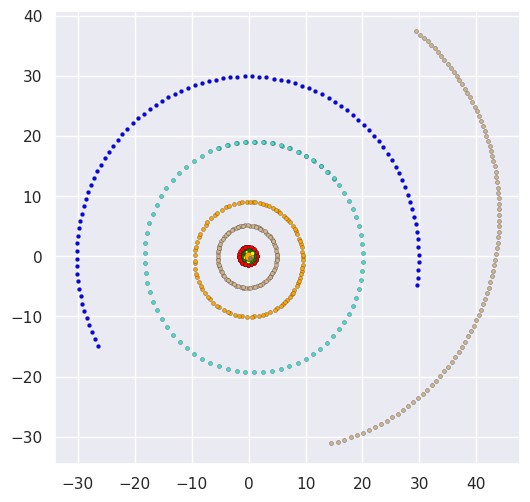

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
# ax.plot(ss_poses[:, :, 0], ss_poses[:, :, 1])
colors = ['orange', 'gray', 'yellow', 'green', 'red', 'tan', 'orange',
          'turquoise', 'blue', 'tan']
for j, t in tqdm.tqdm(list(enumerate(ss_model.times[::10000]))):
    for i, body in enumerate(bodies):
        ax.scatter(ss_model.positions[j * 10000, i, 0],
                   ss_model.positions[j * 10000, i, 1],
                   s=(np.log(1 + ss_masses[i]) * 50 + 8), c=colors[i],
                   edgecolor='k', linewidth=0.2)